In [89]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords # Import the stop word list


import math
import json
import csv
from collections import Counter

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neural_network
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

# Load Data #

* We have selected 10 individuals who are business or social celebrities.

* They are each extremely popular on Twitter and have tens of millions of followers.

In [90]:
elonmusk = pd.read_csv('../data/elonmusk_tweets.csv')
NASA = pd.read_csv('../data/NASA_tweets.csv')
nytimes = pd.read_csv('../data/nytimes_tweets.csv')
espn = pd.read_csv('../data/espn_tweets.csv')
JamesWoods = pd.read_csv('../data/RealJamesWoods_tweets.csv')
katyperry = pd.read_csv('../data/katyperry_tweets.csv')
ScottAdams = pd.read_csv('../data/ScottAdamsSays_tweets.csv')
WilliamShatner = pd.read_csv('../data/WilliamShatner_tweets.csv')
tim_cook = pd.read_csv('../data/tim_cook_tweets.csv')
BillGates = pd.read_csv('../data/BillGates_tweets.csv')

In [91]:
ScottAdams.head()

,text,author
0,"@furburglarr Biased hater, like yourself. Evid...",ScottAdamsSays
1,@theboxerdeli Rarely does any one variable exp...,ScottAdamsSays
2,"@CJFerguson1111 @ejdo0lz The ""vulnerable popul...",ScottAdamsSays
3,@freldmen @JackPosobiec Thanks for noticing!,ScottAdamsSays
4,@CJFerguson1111 @ejdo0lz These studies don't a...,ScottAdamsSays


# Tokenizer #

* Step 1 - Call Beautiful Soup to clean out HTML fragments in tweets.

* Step 2 - Strip url's and keep only letters and numbers

* Step 3 - Strip out utf-8 tags

* Step 4 - Lower case and tokenize

* Note: I do not take out stop words

In [92]:

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def clean_tweet(raw_tweet):
    # 1. Remove HTML
    soup = BeautifulSoup(raw_tweet)
    souped = soup.get_text()
    #
    # 2. Remove non-letters        
    #letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    #
    # 3. Convert to lower case, split into individual words
    lower_case = letters_only.lower()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    #stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    #meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    #return( " ".join( meaningful_words ))   
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()
    

In [93]:
tweeters = [elonmusk,NASA,nytimes,espn,JamesWoods,katyperry,ScottAdams,WilliamShatner,tim_cook,BillGates]
for item in tweeters:
    for i in range(len(item)):
        item['text'][i] = clean_tweet(item['text'][i])

In [94]:
BillGates[:17]

,text,author
0,at smarter advising is helping students go fur...,BillGates
1,glad to see this story told i m always inspire...,BillGates
2,in the early days of microsoft i felt pretty c...,BillGates
3,france has been a leading champion in the figh...,BillGates
4,i recently caught a glimpse at the future of h...,BillGates
5,my visit to made me wish i could be a college ...,BillGates
6,exciting to see how digital tech combined with...,BillGates
7,dollar street is a beautiful reminder that we ...,BillGates
8,rt wants to thankateacher michaela raikes an i...,BillGates
9,cat ladies are everywhere nearly everyone has ...,BillGates


In [95]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
count_vect = CountVectorizer()

In [96]:
total_data =  pd.concat(tweeters)

In [97]:
total_data.tail()

,text,author
2510,my new website is live check out www thegatesn...,BillGates
2511,many people are asking how hey can help in hai...,BillGates
2512,thanks to you and all the other people who hav...,BillGates
2513,thanks for your work on this it will have a re...,BillGates
2514,hello world hard at work on my foundation lett...,BillGates


In [98]:
total_data.head()

,text,author
0,s yes,elonmusk
1,exactly,elonmusk
2,they can form a union whenever they want there...,elonmusk
3,upgrade to the latest s nothing will give you ...,elonmusk
4,soto they are correct it s awesome second best...,elonmusk


In [99]:
X = total_data.drop(['author'])
y = total_data['author']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [101]:
train_data_bow = count_vect.fit_transform(X_train['text'])
test_data_bow = count_vect.transform(X_test['text'])

In [102]:
tfid_vect = TfidfVectorizer()

In [16]:
train_data_tfid = tfid_vect.fit_transform(X_train['text'])

test_data_tfid = tfid_vect.transform(X_test['text'])

In [17]:
train_data_tfid.shape

(19118, 19920)

In [17]:
rfc = ensemble.RandomForestClassifier()
crs = cross_val_score(rfc, train_data_bow, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.47703549  0.48173278  0.48223615  0.45297806  0.48353372  0.46338912
  0.47434555  0.47798742  0.48584906  0.45568956]
Mean of Folds are =  0.47347769088


In [18]:
svc = SVC()
 crs =cross_val_score(svc, train_data_bow, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.12160752  0.12160752  0.12173459  0.12173459  0.12127548  0.12133891
  0.12146597  0.12159329  0.12159329  0.12165705]
Mean of Folds are =  0.121560820584


In [29]:
svcl = SVC(kernel='linear')
crs =cross_val_score(svcl, train_data_bow, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.63308977  0.63152401  0.63113898  0.62068966  0.62624151  0.62656904
  0.6434555   0.61792453  0.62893082  0.63398007]
Mean of Folds are =  0.62935438697


In [18]:
gbc = ensemble.GradientBoostingClassifier()
crs =cross_val_score(gbc, train_data_bow, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.56680585  0.55323591  0.56217346  0.53761755  0.55514898  0.55073222
  0.55863874  0.54035639  0.55765199  0.56056633]
Mean of Folds are =  0.554292742923


In [19]:
lr = LogisticRegression()
crs = cross_val_score(lr, train_data_bow, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.69467641  0.68528184  0.68599791  0.68129572  0.69942499  0.68305439
  0.70052356  0.68658281  0.70178197  0.67960147]
Mean of Folds are =  0.689822106086


In [22]:
lams = [0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]

for lam in lams:
    ridge = LogisticRegression(C=lam, penalty='l2')
    #ridge.fit(train_data_bow, y_train)
    crs = cross_val_score(ridge, train_data_bow, y_train, cv=10)
    print("lam is ",lam)
    print("Cross-Valid Ridge Fold Results are: ",crs)
    print("Mean of Folds are = ",crs.mean())
    
    lasso = LogisticRegression(C=lam, penalty='l1')
    #lasso.fit(train_data_bow, y_train)
    crs = cross_val_score(lasso, train_data_bow, y_train, cv=10)
    print()
    print("Cross-Valid Lasso Fold Results are: ",crs)
    print("Mean of Folds are = ",crs.mean())
    print()
    
    #print("Ridge scoring for {:3f} is {:3f}".format(lam, ridge.score(train_data_bow, y_test)))
    #print("Lasso scoring for {:3f} is {:3f}".format(lam, lasso.score(train_data_bow, y_test)))

lam is  0.01
Cross-Valid Ridge Fold Results are:  [ 0.51356994  0.50626305  0.51358412  0.48641588  0.50548876  0.51202929
  0.50104712  0.48689727  0.51781971  0.50760357]
Mean of Folds are =  0.505071870256

Cross-Valid Lasso Fold Results are:  [ 0.26983299  0.26409186  0.26802508  0.26071055  0.27025614  0.26412134
  0.26544503  0.24895178  0.25786164  0.27372837]
Mean of Folds are =  0.264302476924

lam is  0.1
Cross-Valid Ridge Fold Results are:  [ 0.64352818  0.64300626  0.64211076  0.62382445  0.63460533  0.65115063
  0.64188482  0.62840671  0.64622642  0.64079706]
Mean of Folds are =  0.639554062442

Cross-Valid Lasso Fold Results are:  [ 0.52922756  0.51983299  0.52403344  0.51097179  0.52744381  0.52719665
  0.52460733  0.51415094  0.51991614  0.54011536]
Mean of Folds are =  0.523749600596

lam is  0.2
Cross-Valid Ridge Fold Results are:  [ 0.66231733  0.65866388  0.66405434  0.65360502  0.65917407  0.67468619
  0.66649215  0.64884696  0.66666667  0.6654431 ]
Mean of Folds a

# Experiment with Bigrams #

In [103]:
count_vect_bigram = CountVectorizer(ngram_range=(1,2))
train_data_bow_bigram = count_vect_bigram.fit_transform(X_train['text'])
test_data_bow_bigram = count_vect_bigram.transform(X_test['text'])

In [27]:
crs = cross_val_score(lr, train_data_bow_bigram, y_train, cv=10)
print("Cross-Valid Bigram Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Bigram Fold Results are:  [ 0.69206681  0.69258873  0.69017764  0.68913271  0.71092525  0.68985356
  0.69685864  0.68343816  0.68867925  0.68589407]
Mean of Folds are =  0.69196147956


In [30]:
lams = [0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]

for lam in lams:
    ridge = LogisticRegression(C=lam, penalty='l2')
    #ridge.fit(train_data_bow, y_train)
    crs = cross_val_score(ridge, train_data_bow_bigram, y_train, cv=10)
    print("lam is ",lam)
    print("Cross-Valid Ridge Fold Results are: ",crs)
    print("Mean of Folds are = ",crs.mean())
    
    lasso = LogisticRegression(C=lam, penalty='l1')
    #lasso.fit(train_data_bow, y_train)
    crs = cross_val_score(lasso, train_data_bow_bigram, y_train, cv=10)
    print()
    print("Cross-Valid Lasso Fold Results are: ",crs)
    print("Mean of Folds are = ",crs.mean())
    print()
    

lam is  0.01
Cross-Valid Ridge Fold Results are:  [ 0.54018789  0.52557411  0.53396029  0.50417973  0.52692107  0.5334728
  0.52722513  0.5057652   0.53563941  0.52753015]
Mean of Folds are =  0.526045578993

Cross-Valid Lasso Fold Results are:  [ 0.26983299  0.26409186  0.26802508  0.26071055  0.27025614  0.26359833
  0.26544503  0.24895178  0.25786164  0.27372837]
Mean of Folds are =  0.264250175669

lam is  0.1
Cross-Valid Ridge Fold Results are:  [ 0.65083507  0.65187891  0.65151515  0.64838036  0.64296916  0.65794979
  0.66125654  0.63888889  0.65251572  0.65495543]
Mean of Folds are =  0.651114502749

Cross-Valid Lasso Fold Results are:  [ 0.52974948  0.51826722  0.5276907   0.51044932  0.5300575   0.52876569
  0.52041885  0.51677149  0.52201258  0.54116413]
Mean of Folds are =  0.524534696144

lam is  0.2
Cross-Valid Ridge Fold Results are:  [ 0.67745303  0.67066806  0.66718913  0.66980146  0.67433351  0.67887029
  0.68010471  0.66090147  0.66771488  0.67593078]
Mean of Folds ar

In [31]:
svcl = SVC(kernel='linear')
crs =cross_val_score(svcl, train_data_bow_bigram, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.62787056  0.60960334  0.62330199  0.59874608  0.62467329  0.61140167
  0.62303665  0.60796646  0.60429769  0.61719979]
Mean of Folds are =  0.614809752292


* Adding bigrams is a marginal improvement.

* Logistic Regression does best in cross-validation results.

* Let's do a final experiment adding in trigrams.

# Trigrams #

In [32]:
count_vect_trigram = CountVectorizer(ngram_range=(1,3))
train_data_bow_trigram = count_vect_trigram.fit_transform(X_train['text'])
test_data_bow_trigram = count_vect_trigram.transform(X_test['text'])

In [33]:
crs = cross_val_score(lr, train_data_bow_trigram, y_train, cv=10)
print("Cross-Valid trigram Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid trigram Fold Results are:  [ 0.68058455  0.68058455  0.67972832  0.67972832  0.68949294  0.68671548
  0.69162304  0.67138365  0.67243187  0.67068694]
Mean of Folds are =  0.680295965493


In [34]:
lams = [0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]

for lam in lams:
    ridge = LogisticRegression(C=lam, penalty='l2')
    #ridge.fit(train_data_bow, y_train)
    crs = cross_val_score(ridge, train_data_bow_trigram, y_train, cv=10)
    print("lam is ",lam)
    print("Cross-Valid Ridge Fold Results are: ",crs)
    print("Mean of Folds are = ",crs.mean())
    
    lasso = LogisticRegression(C=lam, penalty='l1')
    #lasso.fit(train_data_bow, y_train)
    crs = cross_val_score(lasso, train_data_bow_trigram, y_train, cv=10)
    print()
    print("Cross-Valid Lasso Fold Results are: ",crs)
    print("Mean of Folds are = ",crs.mean())
    print()
    

lam is  0.01
Cross-Valid Ridge Fold Results are:  [ 0.54018789  0.5276618   0.53500522  0.51201672  0.53110298  0.54131799
  0.52774869  0.50890985  0.54035639  0.53015207]
Mean of Folds are =  0.529445961146

Cross-Valid Lasso Fold Results are:  [ 0.26983299  0.26409186  0.26802508  0.26071055  0.27025614  0.26412134
  0.26544503  0.24895178  0.25786164  0.27372837]
Mean of Folds are =  0.264302476924

lam is  0.1
Cross-Valid Ridge Fold Results are:  [ 0.64874739  0.65031315  0.64681296  0.64576803  0.64453738  0.65219665
  0.65706806  0.63469602  0.64308176  0.65076036]
Mean of Folds are =  0.647398175079

Cross-Valid Lasso Fold Results are:  [ 0.52974948  0.51826722  0.5276907   0.51044932  0.5300575   0.52876569
  0.52041885  0.51624738  0.52201258  0.54116413]
Mean of Folds are =  0.524482285243

lam is  0.2
Cross-Valid Ridge Fold Results are:  [ 0.66858038  0.66701461  0.66196447  0.65935214  0.6649242   0.67207113
  0.67434555  0.65146751  0.6567086   0.66649187]
Mean of Folds a

# Results of Bag of Words Experiments #

* Logistic regression on unigram + bigram features beats all contenders.

# Confusion Matrix #


In [35]:
ats = ['elonmusk','NASA','nytimes','espn','RealJamesWoods','katyperry','ScottAdamsSays','WilliamShatner','tim_cook','BillGates']

Training set score: 0.97567737211

Test set score: 0.686803703123


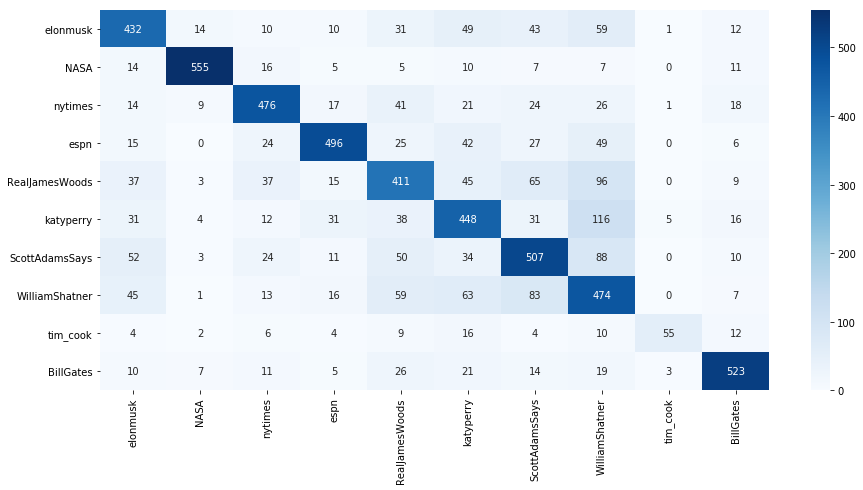

In [37]:
#Confusion matrix for Bigram BOG with Logistic Regression

lr = LogisticRegression()
lr.fit(train_data_bow_bigram,y_train)

print('Training set score:', lr.score(train_data_bow_bigram, y_train))
print('\nTest set score:', lr.score(test_data_bow_bigram, y_test))

y_pred = lr.predict(test_data_bow_bigram)

conf = confusion_matrix(y_test, y_pred, labels = ats)

cm = pd.DataFrame(conf, index = [i for i in ats],
                  columns = [i for i in ats])
plt.figure(figsize = (15,7))
sns.heatmap(cm, annot=True, cmap="Blues", fmt = 'd')

# Using TF-IDF Features #

In [20]:
tfidf_vector =  TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=False, sublinear_tf=True,
                                max_df=0.5, # drop words with df of greater than .5                                
                                min_df=2, # words must occur twice
                                stop_words='english', 
                                lowercase=True, # lowercase everything
                               )

train_data_tfidf = tfidf_vector.fit_transform(X_train['text'])
test_data_tfidf = tfidf_vector.transform(X_test['text'])


In [21]:
train_data_tfidf.shape

(19118, 10202)

In [22]:
rfc = ensemble.RandomForestClassifier()
crs = cross_val_score(rfc, train_data_tfidf, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.56784969  0.56367432  0.56792059  0.5585162   0.56717198  0.55439331
  0.55706806  0.56132075  0.56341719  0.56109072]
Mean of Folds are =  0.562242280331


In [23]:
svcl = SVC(kernel='linear')
crs =cross_val_score(svcl, train_data_tfidf, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.64979123  0.66753653  0.65517241  0.65569488  0.65499216  0.66213389
  0.65445026  0.66037736  0.66457023  0.65233351]
Mean of Folds are =  0.657705246894


In [24]:
gbc = ensemble.GradientBoostingClassifier()
crs =cross_val_score(gbc, train_data_tfidf, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.532881    0.51983299  0.53709509  0.52560084  0.52796654  0.53556485
  0.53874346  0.53249476  0.54454927  0.53644468]
Mean of Folds are =  0.533117346865


In [25]:
lr = LogisticRegression()
crs = cross_val_score(lr, train_data_tfidf, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.66805846  0.65501044  0.66353187  0.66196447  0.66596968  0.6710251
  0.65811518  0.67295597  0.66457023  0.66019927]
Mean of Folds are =  0.664140067656


In [26]:
lams = [0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]

for lam in lams:
    ridge = LogisticRegression(C=lam, penalty='l2')
    #ridge.fit(train_data_bow, y_train)
    crs = cross_val_score(ridge, train_data_tfidf, y_train, cv=10)
    print("lam is ",lam)
    print("Cross-Valid Ridge Fold Results are: ",crs)
    print("Mean of Folds are = ",crs.mean())
    
    lasso = LogisticRegression(C=lam, penalty='l1')
    #lasso.fit(train_data_bow, y_train)
    crs = cross_val_score(lasso, train_data_tfidf, y_train, cv=10)
    print()
    print("Cross-Valid Lasso Fold Results are: ",crs)
    print("Mean of Folds are = ",crs.mean())
    print()

lam is  0.01
Cross-Valid Ridge Fold Results are:  [ 0.29436326  0.28914405  0.29571578  0.29832811  0.29168845  0.31066946
  0.31099476  0.29926625  0.30293501  0.30309386]
Mean of Folds are =  0.299619898454

Cross-Valid Lasso Fold Results are:  [ 0.12160752  0.12160752  0.12173459  0.12173459  0.12127548  0.12133891
  0.12146597  0.12159329  0.12159329  0.12165705]
Mean of Folds are =  0.121560820584

lam is  0.1
Cross-Valid Ridge Fold Results are:  [ 0.57254697  0.57202505  0.58411703  0.57732497  0.57030842  0.5957113
  0.59528796  0.59433962  0.58018868  0.58573676]
Mean of Folds are =  0.58275867638

Cross-Valid Lasso Fold Results are:  [ 0.36273486  0.35020877  0.36729363  0.35161964  0.35546262  0.35512552
  0.36387435  0.3490566   0.36111111  0.36497116]
Mean of Folds are =  0.358145826969

lam is  0.2
Cross-Valid Ridge Fold Results are:  [ 0.6085595   0.60281837  0.6123302   0.6138976   0.61160481  0.62029289
  0.61937173  0.62264151  0.610587    0.61615102]
Mean of Folds are

# With Stop Words #

In [19]:
tfidf_vector1 =  TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=False, sublinear_tf=True,
                                max_df=0.5, # drop words with df of greater than .5                                
                                min_df=2, # words must occur twice 
                                lowercase=True, # lowercase everything
                               )

train_data_tfidf1 = tfidf_vector1.fit_transform(X_train['text'])
test_data_tfidf1 = tfidf_vector1.transform(X_test['text'])


In [20]:
lr = LogisticRegression()
crs = cross_val_score(lr, train_data_tfidf1, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.67745303  0.66649269  0.66666667  0.669279    0.67903816  0.68305439
  0.67486911  0.66457023  0.67819706  0.67226009]
Mean of Folds are =  0.673188043698


* Results improve marginally with stop words included

In [21]:
ats = ['elonmusk','NASA','nytimes','espn','RealJamesWoods','katyperry','ScottAdamsSays','WilliamShatner','tim_cook','BillGates']

Training set score: 0.81525264149

Test set score: 0.679899576338


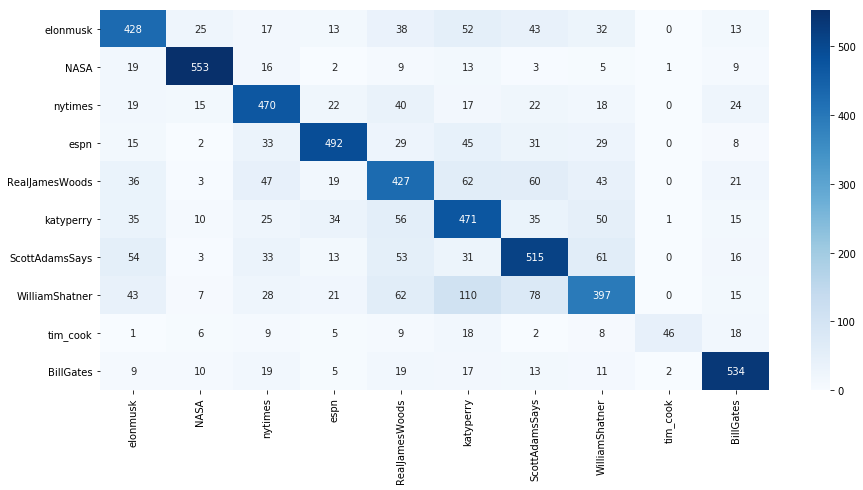

In [32]:
#Confusion matrix for Bigram BOG with Logistic Regression

lr = LogisticRegression()
lr.fit(train_data_tfidf1,y_train)

print('Training set score:', lr.score(train_data_tfidf1, y_train))
print('\nTest set score:', lr.score(test_data_tfidf1, y_test))

y_pred = lr.predict(test_data_tfidf1)

conf = confusion_matrix(y_test, y_pred, labels = ats)

cm = pd.DataFrame(conf, index = [i for i in ats],
                  columns = [i for i in ats])
plt.figure(figsize = (15,7))
sns.heatmap(cm, annot=True, cmap="Blues", fmt = 'd')

# Tfidf Results #

* Overall results are slightly better with Bag of Word - Unigram + Bigram

# Experiments with Clustering - KMeans and LSA #

In [65]:
X = total_data['text']
y = total_data['author']

In [72]:
# normalize Tfidf data with stop words to kmeans cluster
# tfidf and kmeans clustering on entire X dataset for unsupervised purposes

# X = total_data.drop(['author'])
# y = total_data['author']

X_tfidf = tfidf_vector1.fit_transform(X)
#print(X_tfidf)
from sklearn.preprocessing import normalize
normX_tfidf = normalize(X_tfidf)

# use kmeans  minibatch on 4 clusters

kmeans = MiniBatchKMeans(n_clusters=4, init='k-means++', batch_size=500)
kmeans.fit(normX_tfidf)

# get some metrics on our data

print("Homogeneity Score is: {:.3f}".format(metrics.homogeneity_score(y, kmeans.labels_)))
print("Completeness Score: {:.3f}".format(metrics.completeness_score(y, kmeans.labels_)))
print("V-measure Score: {:.3f}".format(metrics.v_measure_score(y, kmeans.labels_)))
print("Adjusted Rand-Index Score: {:.3f}".format(metrics.adjusted_rand_score(y, kmeans.labels_)))
print("Silhouette Coefficient Score: {:.3f}".format(metrics.silhouette_score(normX_tfidf, kmeans.labels_, sample_size=5000)))

Homogeneity Score is: 0.018
Completeness Score: 0.039
V-measure Score: 0.025
Adjusted Rand-Index Score: 0.007
Silhouette Coefficient Score: 0.008


In [73]:
# Scores in general are low
# Clustering in tfidf space is probably not effective
X = total_data
X['kmcluster'] = kmeans.labels_

In [74]:
from sklearn.utils import shuffle

# Cluster 0 #

In [75]:
print(shuffle(X[X.kmcluster == 0][['text','author']]).head(30))

                                                   text          author
1740  people go on a cruise to see beautiful islands...         nytimes
1606  the new york times is observing worldpressfree...         nytimes
854       prior to implementation of the iran nuke deal  ScottAdamsSays
2247  that s the point if the perma hawk says we hav...  ScottAdamsSays
188   don t want to brag or anything but that happen...        elonmusk
318   albert pujols got his first career hit years a...            espn
329   maybe the most underrated dramatic actor ever ...  RealJamesWoods
2413                                    katy x moschino       katyperry
760   a veritable no man s land off the coast of sco...         nytimes
143   he carried out the killing then he questioned ...         nytimes
713   no i can t say i ve ever thought about being a...  WilliamShatner
1349  i hear him say he doesn t want to be part of t...  ScottAdamsSays
710      we need to keep narrowing the unpaid labor gap       Bi

# Cluster 1 #

In [76]:
print(shuffle(X[X.kmcluster == 1][['text','author']]).head(30))

                                                   text          author
477   looking for a book to enjoy over the holidays ...       BillGates
1460  nice piece on a high tech pedicab and other in...       BillGates
1387  the daca scam is a plan to pervert our sacred ...  RealJamesWoods
1097           if only that were an option in this case  ScottAdamsSays
1837  tony hey from recaps the global grand challeng...       BillGates
574   here s a great investment stellar dataviz from...       BillGates
2153  johnson based testing team from spent labor da...            NASA
1966                      trae young from the panhandle            espn
1304  my blog post about kanye s linguistic talent f...  ScottAdamsSays
1846  i m co hosting the w my friend this weekend li...       katyperry
111                         here s one theory from time  ScottAdamsSays
923   this is the kind of innovation we need produci...       BillGates
1935         would watch sports with this very good boy         

# Results on KMeans Clustering #

* In general, I defy anyone to make any sense of it at all.

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X['text'], 
                                                    X['author'], test_size = 0.25, random_state = 42)

In [105]:
normX_train_tfidf = normalize(tfidf_vector1.fit_transform(X_train))
normX_test_tfidf = normalize(tfidf_vector1.transform(X_test))


km = MiniBatchKMeans(n_clusters=4, init='k-means++', batch_size=5000)

km.fit(normX_train_tfidf)
km_train_label = km.labels_
km_test_label = km.predict(normX_test_tfidf)

In [113]:
from scipy.sparse import coo_matrix, hstack

X_train_km = hstack([train_data_bow_bigram,pd.DataFrame(km_train_label)])
X_test_km = hstack([test_data_bow_bigram,pd.DataFrame(km_test_label)])

In [115]:
lr = LogisticRegression()
lr.fit(X_train_km,y_train)

print('Training set score:', lr.score(X_train_km, y_train))
print('\nTest set score:', lr.score(X_test_km, y_test))



Training set score: 0.97599121247

Test set score: 0.688529734819


# Results #

* Adding kmeans clusters to Bag of Words data appears to improve things slightly.

* Not a huge effect

# TFIDF with LDA #

In [119]:
tfidf_vector1 =  TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=False, sublinear_tf=True,
                                max_df=0.5, # drop words with df of greater than .5                                
                                min_df=2, # words must occur twice 
                                lowercase=True, # lowercase everything
                               )

train_data_tfidf1 = tfidf_vector1.fit_transform(X_train)
test_data_tfidf1 = tfidf_vector1.transform(X_test)

In [121]:
svd= TruncatedSVD(250)

lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(train_data_tfidf1)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(10):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 30.7649064677
Component 0:
text
wherein the finally passes in the race to the edge of the lemming cliff                                              0.571999
a judge denied cbs s bid to strip shari redstone of control of the company the ruling is a blow to the cbs chief     0.570986
in moment of delicious irony it finally took a gaggle of dirtydemocrats and leeringliberals to push the              0.566497
in attempting to reduce the trade deficit chinese negotiators are preparing to offer the u s a package of promise    0.563785
is it a surprise to anyone here that you live in a geographically undesirable part of the the country                0.547777
i quote a california friend of mine the billion dollars that the moonbeam government wants to squander on the        0.536184
i know that closet is nice and warm but it s time you admitted you are one of the creators of the ne                 0.525345
the checkup in lullabies a chance for par

# Meanings of LDA Components #

* The first component is composed of long coherent sentences.

* The second component is composed of sentences that talk about action to 'you' or 'yourself'.

* The third component is composed of basically 'yes' responses

* The fourth component is composed of short sentences with 'it is' in them.

* the fifth component is composed of short sentences with 'this is' in them.

In [123]:
X_test_lsa = lsa.transform(test_data_tfidf1)

In [124]:
X_train_combo = hstack([X_train_km, X_train_lsa])
X_test_combo = hstack([X_test_km, X_test_lsa])

In [126]:
lr = LogisticRegression()
crs = cross_val_score(lr, X_train_combo, y_train, cv=10)
print("Cross-Valid Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())

Cross-Valid Fold Results are:  [ 0.69467641  0.69050104  0.69487983  0.69017764  0.70203868  0.69299163
  0.6973822   0.68763103  0.68710692  0.68694284]
Mean of Folds are =  0.692432822539


In [127]:
lams = [0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]

for lam in lams:
    ridge = LogisticRegression(C=lam, penalty='l2')
    #ridge.fit(train_data_bow, y_train)
    crs = cross_val_score(ridge, X_train_combo, y_train, cv=10)
    print("lam is ",lam)
    print("Cross-Valid Ridge Fold Results are: ",crs)
    print("Mean of Folds are = ",crs.mean())
    
    lasso = LogisticRegression(C=lam, penalty='l1')
    #lasso.fit(train_data_bow, y_train)
    crs = cross_val_score(lasso, X_train_combo, y_train, cv=10)
    print()
    print("Cross-Valid Lasso Fold Results are: ",crs)
    print("Mean of Folds are = ",crs.mean())
    print()

lam is  0.01
Cross-Valid Ridge Fold Results are:  [ 0.55532359  0.53601253  0.54963427  0.52821317  0.54260324  0.55543933
  0.53874346  0.5351153   0.55450734  0.53854221]
Mean of Folds are =  0.543413443826

Cross-Valid Lasso Fold Results are:  [ 0.26304802  0.26409186  0.26698015  0.2539185   0.2843701   0.27144351
  0.25759162  0.23951782  0.2557652   0.26586261]
Mean of Folds are =  0.262258938363

lam is  0.1
Cross-Valid Ridge Fold Results are:  [ 0.65814196  0.64822547  0.65517241  0.64890282  0.64715107  0.65899582
  0.65706806  0.64675052  0.65513627  0.66596749]
Mean of Folds are =  0.654151189826

Cross-Valid Lasso Fold Results are:  [ 0.53601253  0.52453027  0.52873563  0.52089864  0.52953476  0.5292887
  0.53193717  0.52201258  0.53406709  0.54116413]
Mean of Folds are =  0.529818150584

lam is  0.2
Cross-Valid Ridge Fold Results are:  [ 0.68058455  0.66962422  0.67398119  0.67084639  0.67067433  0.67991632
  0.67905759  0.66509434  0.6687631   0.67435763]
Mean of Folds ar

* best overall results are with Uni-bigrams Bag of Words with LDA features added using Logistic Regression.